In [99]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import skew, kurtosis, mode, zscore, norm
from scipy.special import boxcox1p

# Pipeline and machine learning algorithms
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [100]:
# It is your job to predict the sales price for each house. 
# For each Id in the test set, you must predict the value of the SalePrice variable. 

# Load Data and Explore

Join Train and Test set so changes are made on both

In [101]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
test2=pd.read_csv("test.csv")


In [102]:
# delteing the outliers, this should be done later but I forgot

train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)]
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [103]:
len_train=train.shape[0]
houses=pd.concat([train,test], sort=False)
print(train.shape)
print(test.shape)

(1458, 81)
(1459, 80)


# Exploratory data analysis (EDA)

In [104]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [105]:
#train.info()

In [106]:
#houses.info()

In [107]:
houses.select_dtypes(include='object').head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [108]:
houses.select_dtypes(include=['float','int']).head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,61,0,0,0,0,0,2,2008,208500.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,298,0,0,0,0,0,0,5,2007,181500.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,42,0,0,0,0,0,9,2008,223500.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,35,272,0,0,0,0,2,2006,140000.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,192,84,0,0,0,0,0,12,2008,250000.0


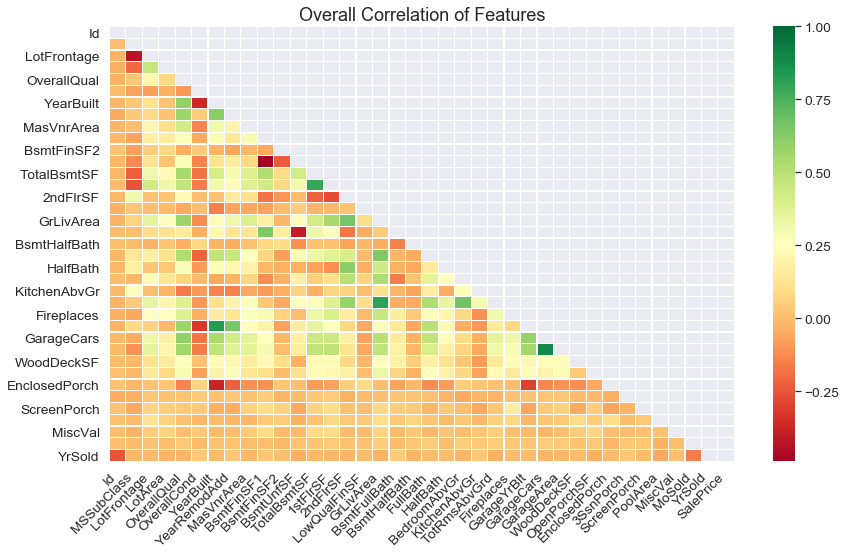

In [109]:
# Initiate correlation matrix
corrmat = houses.corr()

# Set-up mask
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set-up figure
plt.figure(figsize=(14, 8))
plt.title('Overall Correlation of Features', fontsize=18)
ax = sns.heatmap(corrmat, mask=mask, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})

# Fix bug in heatmap to display full high rows on top and bottom
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

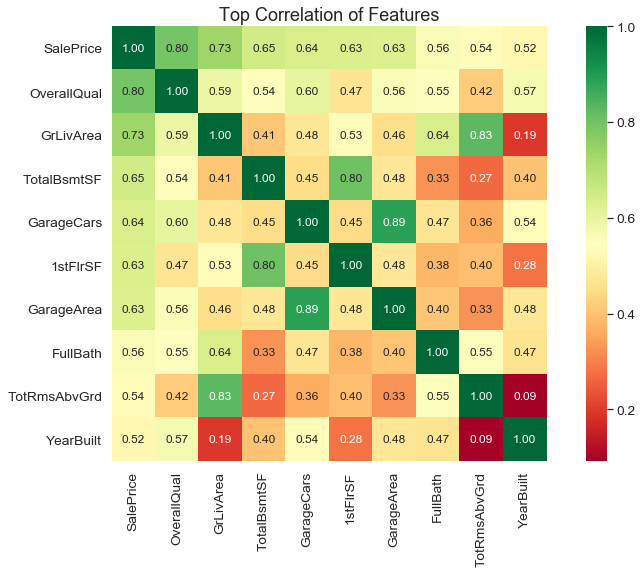

In [110]:
#saleprice correlation matrix
#set top number of variables for heatmap
k = 10 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)

plt.figure(figsize=(14, 8))
plt.title('Top Correlation of Features', fontsize=18)
sns.set(font_scale=1.25)
ax = sns.heatmap(cm, cbar=True, annot=True, cmap='RdYlGn', square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

In [111]:
houses.select_dtypes(include='object').isnull().sum()[houses.select_dtypes(include='object').isnull().sum()>0]

MSZoning           4
Alley           2719
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2908
Fence           2346
MiscFeature     2812
SaleType           1
dtype: int64

# Create new features

In [112]:
# houses['TotalBsmtSF'] = houses['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
# houses['2ndFlrSF'] = houses['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
# houses['GarageArea'] = houses['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
# houses['GarageCars'] = houses['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
# houses['LotFrontage'] = houses['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
# houses['MasVnrArea'] = houses['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
# houses['BsmtFinSF1'] = houses['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
# houses['haspool'] = houses['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
# houses['has2ndfloor'] = houses['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
# houses['hasgarage'] = houses['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
# houses['hasbsmt'] = houses['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
# houses['hasfireplace'] = houses['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Dropping low variance features

In [113]:
# Saving all features for future comparison.
all_features = houses.keys()
# Removing features.
houses = houses.drop(houses.loc[:,(houses==0).sum()>=(houses.shape[0]*0.984)],axis=1)
houses = houses.drop(houses.loc[:,(houses==1).sum()>=(houses.shape[0]*0.984)],axis=1) 
# Getting and printing the remaining features.
remain_features = houses.keys()
remov_features = [st for st in all_features if st not in remain_features]
print(len(remov_features), 'features were removed:', remov_features)

3 features were removed: ['LowQualFinSF', '3SsnPorch', 'PoolArea']


# Feature engineering

In [114]:
houses = houses.drop(['Utilities', 'Street', 'PoolQC', 'LandSlope', 'Exterior2nd'], axis=1)

In [115]:
houses["MiscFeature"] = houses["MiscFeature"].fillna("None")
houses["Alley"] = houses["Alley"].fillna("None")
houses["Fence"] = houses["Fence"].fillna("None")
houses["FireplaceQu"] = houses["FireplaceQu"].fillna("None")

In [116]:
houses["LotFrontage"] = houses.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [117]:
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    houses[col] = houses[col].fillna('None')

In [118]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    houses[col] = houses[col].fillna(0)

In [119]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    houses[col] = houses[col].fillna(0)

In [120]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    houses[col] = houses[col].fillna('None')

In [121]:
houses["MasVnrType"] = houses["MasVnrType"].fillna("None")
houses["MasVnrArea"] = houses["MasVnrArea"].fillna(0)

In [122]:
houses['MSZoning'] = houses['MSZoning'].fillna(houses['MSZoning'].mode()[0])
houses["Functional"] = houses["Functional"].fillna("Typ")
houses['MSSubClass'] = houses['MSSubClass'].fillna("None")

In [123]:
mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'SaleType']
for col in mode_col:
    houses[col] = houses[col].fillna(houses[col].mode()[0])

In [124]:
#Check remaining missing values if any 
houses_na = (houses.isnull().sum() / len(houses)) * 100
houses_na = houses_na.drop(houses_na[houses_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :houses_na})
missing_data.head()

,Missing Ratio
SalePrice,50.017141


In [125]:
# Converting some numerical variables that are really categorical type.
houses['MSSubClass'] = houses['MSSubClass'].apply(str)
houses['OverallCond'] = houses['OverallCond'].astype(str)
houses['YrSold'] = houses['YrSold'].astype(str)
houses['MoSold'] = houses['MoSold'].astype(str)

# Label Encoding

In [126]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish',
        'LotShape', 'PavedDrive', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(houses[c].values)) 
    houses[c] = lbl.transform(list(houses[c].values))

# shape        
print('Shape all_data: {}'.format(houses.shape))

Shape all_data: (2917, 73)


In [127]:
houses['TotalSF'] = houses['TotalBsmtSF'] + houses['1stFlrSF'] + houses['2ndFlrSF']

# Fix Skewness in Data

In [128]:
skewness = pd.DataFrame(houses.skew(axis = 0, skipna = True).sort_values(ascending=False), columns=['Skew'])
skewness.dropna()
skewness

,Skew
MiscVal,21.950962
LotArea,13.116240
KitchenAbvGr,4.302763
BsmtFinSF2,4.146636
EnclosedPorch,4.004404
ScreenPorch,3.947131
BsmtHalfBath,3.932018
MasVnrArea,2.623068
OpenPorchSF,2.530660
SalePrice,1.881296


In [129]:
skewnessdf = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewnessdf.shape[0]))

There are 55 skewed numerical features to Box Cox transform


In [131]:
skewed_features = skewnessdf.index
lam = 0.15
for feat in skewed_features:
    if feat != 'SalePrice':
        houses[feat]=  boxcox1p(houses[feat], lam)

In [132]:
pd.DataFrame(houses.skew(axis = 0, skipna = True).sort_values(ascending=False), columns=['Skew'])

,Skew
MiscVal,5.597842
BsmtHalfBath,3.788634
KitchenAbvGr,3.699206
ScreenPorch,2.978584
BsmtFinSF2,2.564554
EnclosedPorch,2.025363
SalePrice,1.881296
MasVnrArea,0.637716
HalfBath,0.592853
BsmtFullBath,0.442015


In [133]:
houses=pd.get_dummies(houses)
houses

,Id,MSSubClass,LotFrontage,LotArea,Alley,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.730463,2.885846,5.831328,19.212182,0.730463,1.540963,2.440268,1.820334,14.187527,14.187527,...,0,0,0,1,0,0,0,0,1,0
1,1.194318,2.055642,6.221214,19.712205,0.730463,1.540963,2.259674,2.440268,14.145138,14.145138,...,0,0,0,1,0,0,0,0,1,0
2,1.540963,2.885846,5.914940,20.347241,0.730463,0.000000,2.440268,1.820334,14.184404,14.185966,...,0,0,0,1,0,0,0,0,1,0
3,1.820334,3.011340,5.684507,19.691553,0.730463,0.000000,2.440268,1.820334,14.047529,14.135652,...,0,0,0,1,1,0,0,0,0,0
4,2.055642,2.885846,6.314735,21.325160,0.730463,0.000000,2.602594,1.820334,14.182841,14.182841,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,15.394418,1.194318,3.932510,14.081426,0.730463,1.540963,1.820334,2.259674,14.135652,14.135652,...,0,0,0,1,0,0,0,0,1,0
1455,15.395553,1.194318,3.932510,14.013314,0.730463,1.540963,1.820334,1.820334,14.135652,14.135652,...,0,0,0,1,1,0,0,0,0,0
1456,15.396687,2.055642,7.620056,22.782058,0.730463,1.540963,2.055642,2.259674,14.119786,14.176584,...,0,0,0,1,1,0,0,0,0,0
1457,15.397821,3.340760,5.744420,20.046557,0.730463,1.540963,2.055642,1.820334,14.170316,14.170316,...,0,0,0,1,0,0,0,0,1,0


In [134]:
train=houses[:len_train]
test=houses[len_train:]

In [135]:
train['SalePrice']=np.log(train['SalePrice'])

In [136]:
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [137]:
X_train =train.drop('SalePrice', axis=1)
y_train =train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

# Build and Train Models

In [138]:
sc = RobustScaler()
X_train =sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [139]:
# Initialize our model
# With huber loss that makes it robust to outliers
kf = KFold(n_splits=10)
g_boost = GradientBoostingRegressor( n_estimators=6000, learning_rate=0.01,
                                     max_depth=5,
                                     min_samples_leaf=15, min_samples_split=10,
                                     loss='huber', random_state =42
                                   )
g_boost_pred = cross_val_score(g_boost, X_train, y_train, cv=kf,  scoring="neg_mean_squared_error", n_jobs=-1)
gboost = np.sqrt(-g_boost_pred)
print("\nGboots score: {:.4f} ({:.4f})\n".format(gboost.mean(), gboost.std()))


Gboots score: 0.1231 (0.0170)



In [140]:
# Initialize our model
kf = KFold(n_splits=10)
ridge = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
ridge_pred = cross_val_score(ridge, X_train, y_train, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1)
rmser = np.sqrt(-ridge_pred)
print("\nRidgescore: {:.4f} ({:.4f})\n".format(rmser.mean(), rmser.std()))


Ridgescore: 0.1145 (0.0168)



In [141]:
kf = KFold(n_splits=10)
lr = LinearRegression()
lr_pred = cross_val_score(lr, X_train, y_train, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1)
rmsel = np.sqrt(-lr_pred)
print("\nLasso score: {:.4f} ({:.4f})\n".format(rmsel.mean(), rmsel.std()))


Lasso score: 782062.9857 (2346188.5923)



In [142]:
# Initialize our model
# This model may be very sensitive to outliers. So we need to made it more robust on them.
# For that we use the sklearn's Robustscaler() method on pipeline
kf = KFold(n_splits=10)
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso_pred = cross_val_score(lasso, X_train, y_train, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1)
rmsel = np.sqrt(-lasso_pred)
print("\nLasso score: {:.4f} ({:.4f})\n".format(rmsel.mean(), rmsel.std()))


Lasso score: 0.1099 (0.0139)



In [143]:
kf = KFold(n_splits=10)
elnet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
elnet_pred = cross_val_score(elnet, X_train, y_train, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1)
rmsee = np.sqrt(-elnet_pred)
print("\nelnet score: {:.4f} ({:.4f})\n".format(rmsee.mean(), rmsee.std()))


elnet score: 0.1098 (0.0139)



In [144]:
kf = KFold(n_splits=5)
svr = SVR(kernel = 'poly')
svr_pred = cross_val_score(svr, X_train, y_train, cv=kf,scoring="neg_mean_squared_error",n_jobs=-1)
rmsek = np.sqrt(-svr_pred)
print("\nsvr score: {:.4f} ({:.4f})\n".format(rmsek.mean(), rmsek.std()))


svr score: 0.3675 (0.0540)



# Apply Grid Search for Best Parameters

In [145]:
# Gridsearch g_boost
param_grid={'n_estimators':[100], 
            'learning_rate': [0.1],
            'max_depth':[6],#4,6],
            'min_samples_leaf':[3],
            'max_features':[1.0],}

In [146]:
# Grid Search for Gradiant Boosting Regression
kf = KFold(n_splits=5)
grid1 = GridSearchCV(g_boost, param_grid, cv=kf, verbose = 1, scoring = 'neg_mean_squared_error', n_jobs = -1)
grid1.fit(X_train, y_train)
scores1 = grid1.cv_results_['mean_test_score']
best_params1 = grid1.best_params_ 
best_score1 = np.round(np.sqrt(-1 * grid1.best_score_), 5)
print(best_params1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


{'learning_rate': 0.1, 'max_depth': 6, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 100}


# Create a pipeline to analyse the model

In [147]:
# Create pipeline
# Create a pipeline of three steps. First, standardize the data.
# Second, tranform the data with PCA.
# Third, train a Decision Tree Classifier on the data.
rs = RobustScaler()
enet = ElasticNet()
pipe = Pipeline(steps=[('rs', rs),
                       ('elasticnet', enet)])

In [148]:
# Create parameters 
n_components = list(range(1,X_train.shape[1]+1,1))
normalize = [True, False]
selection = ['cyclic', 'random']
alpha=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
maxiter=[1, 5, 10,20,40,80]

parameters = dict(elasticnet__alpha=alpha,
                  elasticnet__max_iter=maxiter,
                  elasticnet__normalize=normalize,
                  elasticnet__selection=selection)

In [149]:
clf = GridSearchCV(pipe, parameters)
clf.fit(X_train, y_train)
scores1 = clf.cv_results_['mean_test_score']
print(); print(clf.best_estimator_.get_params()['elasticnet'])


ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=80, normalize=False, positive=False, precompute=False,
           random_state=None, selection='random', tol=0.0001, warm_start=False)


In [150]:
# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1, scoring='r2',verbose=10)
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   45.3s remaining:   45.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   45.5s remaining:   19.5s



[0.91683143 0.9410704  0.94105686 0.91790371 0.90299749 0.91482867
 0.91635331 0.93138462 0.93413131 0.91198478]

0.9228542589358135

0.0124217280050523


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


In [151]:
print("Accuracy: %0.2f (+/- %0.2f)" % (CV_Result.mean(), CV_Result.std() * 2))

Accuracy: 0.92 (+/- 0.02)


In [152]:
Y_pred = grid.predict(X_test)

NameError: name 'grid' is not defined

# Run model with final parameters

In [153]:
kf = KFold(n_splits=10)
g_boost = GradientBoostingRegressor( n_estimators=100, learning_rate=0.1,
                                     max_depth=6, max_features='sqrt',
                                     min_samples_leaf=3,random_state =42
                                   )
g_boost_pred = cross_val_score(g_boost, X_train, y_train, cv=kf, n_jobs=-1)
g_boost_pred.mean()

0.9061804616031092

In [154]:
# Initialize our model
kf = KFold(n_splits=10)
ridge = KernelRidge(alpha=2, kernel='poly', degree=2, coef0=2.5)
ridge_pred = cross_val_score(ridge, X_train, y_train, cv=kf, n_jobs=-1)
ridge_pred.mean()

0.9137705895667881

In [155]:
# Initialize our model
kf = KFold(n_splits=10)
ridge = KernelRidge(alpha=2, kernel='poly', degree=2, coef0=2.5)
ridge_pred = cross_val_score(ridge, X_train, y_train, cv=kf, n_jobs=-1)
ridge_pred.mean()

0.9137705895667881

In [156]:
# Initialize our model
kf = KFold(n_splits=5)
lasso = Lasso(alpha =0.0037065129109221566, random_state=1)
lasso_pred = cross_val_score(lasso, X_train, y_train, cv=kf, n_jobs=-1)
lasso_pred.mean()

0.9054398989029806

In [157]:
kf = KFold(n_splits=10)
elnet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0004,max_iter=1700, l1_ratio=0.9, random_state=5))
elnet_pred = cross_val_score(elnet, X_train, y_train, cv=kf, n_jobs=-1)
elnet_pred.mean()

0.9236127837329292

# Final Prediction

In [ ]:
# elnet.fit(X_train, y_train)
pred = clf.predict(X_test)

In [89]:
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)

In [91]:
preds=np.exp(pred)

In [92]:
output=pd.DataFrame({'Id':test2.Id, 'SalePrice':preds})
output.to_csv('DSKsubmission.csv', index=False)

In [93]:
output

,Id,SalePrice
0,1461,115506.472264
1,1462,155114.200277
2,1463,180309.120394
3,1464,191395.116240
4,1465,197924.200661
...,...,...
1454,2915,88078.371474
1455,2916,79218.595185
1456,2917,172858.704940
1457,2918,116683.763285
